In [1]:
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [130]:
class Value:
    def __init__(self, data, _parent = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_parent) #here we convert the tuple to a set for efficiency purposes
        self._op = _op
        self.label = label #this here allows us to provide a label also for each of the value object
        self.grad = 0.0 #this is the slope of the output variable w.r.t to the given variable (here variable is a Value object)
        self._backward = lambda: None

    def __repr__(self):
        return f"{self.data}"

    #now we want to add two value objects so we defne a method for that
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other,label = 'const') #checks if other is a Value obj. if not it wraps it in the obj.
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self+other

    ''' 
    def __sub__(self , other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')
        def _backward():
            self.grad = 1* out.grad
            other.grad = -1*out.grad
        out._backward = backward
        return out
    '''
    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1

   
    #method to multiply two value objects
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other,label = 'const') #checks if other is a Value obj. if not it wraps it in the obj.
        out = Value(self.data*other.data, (self, other), '*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self*other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data*out.grad #this makes sense as we'd already have the grad of it when backpropagating
        out._backward = _backward
        return out

    ''' def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        if other.data == 0:
            print('Division via O is not possible')
        out = Value(self.data/other.data, (self, other), '/')
        def _backward():
            self.grad = 1/other.data
            other.grad = self.data/(other.data**2)
        out._backward = _backward
        return out 
        
    def __rtruediv__(self, other):
        return self/other 
    '''
    #we don't use the above method for divison as it lacks generality and can't process operations of type int/obj .

    def __truediv__(self,other):
        return self * other**-1

    def __pow__(self , other):
        assert isinstance(other, (int, float)) #atm it will support only the integer and floar powers
        out = Value(math.pow(self.data, other), (self, ), 'pow')
        def _backward():
            self.grad += other*(self.data**(other-1))*out.grad
        out._backward = _backward
        return out
        
    #method to use activation func 'tanh'
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) +1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2)*out.grad
        out._backward = _backward
        return out

    def backprop(self):
       topo = []
       visited = set()
       def build_topo(v):
           if v not in visited:
              visited.add(v)
              for child in v._prev:
                  build_topo(child)
              topo.append(v)
       build_topo(self)

       self.grad = 1.0
       for node in reversed(topo):
           node._backward()


In [113]:
#now we want  a function to visualise these networks as they start to become more complex
from graphviz import Digraph

def trace(root): #build a set of all the nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for parent in v._prev:
                edges.add((parent, v))
                build(parent)

    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph create a rectangula node for it "record"
        dot.node(name = uid, label = "{%s = data %.4f | grad = %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            #if value is the result of some operation then we create an operation node for it
            dot.node(name=uid+n._op, label = n._op)
            #connect the node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the operations node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

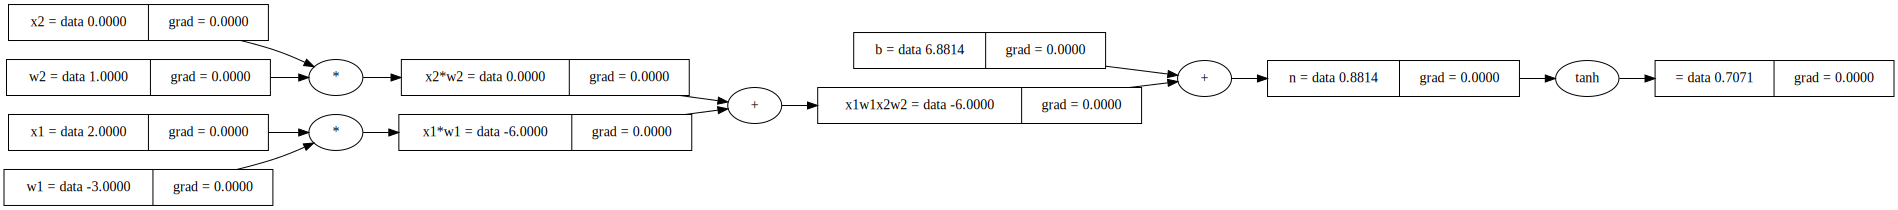

In [135]:
#writing the equation for a neuron
#inputs x1 and x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1 and w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#the bias 'b'
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
#the variable before activation function
n = x1w1x2w2 + b; n.label = 'n'

#now we apply the activation function and then get the final value
o = n.tanh()
draw_dot(o)


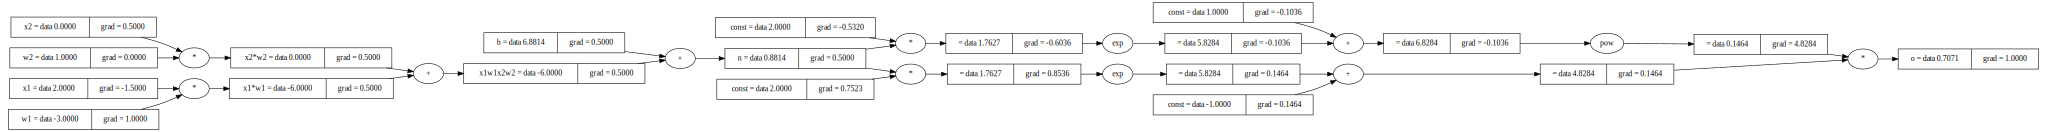

In [136]:
#now we will break up the tanh and use exponentiation subtraction and division tanh(x) = (e^2x - 1)/(e^2x + 1)
n1 = (n*2).exp() - 1
d1 = (n*2).exp() + 1
o = n1/d1
o.label = 'o'
o.backprop()
draw_dot(o)